# Example Project

We're going to import Twitter data into Neo4j and then do various analysis on top of this dataset including plotting, graph algorithms, and graph visualizations.

# Import

The script for importing data from Twitter's API is in `scripts/twitter.py`. This was used to upload tweets that contained either the words "python", "rstats", or "neo4j" to Neo4j.

In [1]:
from scripts.vis import draw
from py2neo import Graph

graph = Graph()
options = {"User": "username", "Hashtag": "name"}

draw(graph, options, physics=True, limit=30)

# Plotting

Let's gather some basic insights by creating `plotly` charts.

In [2]:
%load_ext cypher
import plotly.plotly as py
from plotly.graph_objs import *

# What are the top hashtags?

Find hashtags ordered by the number of tweets they've tagged.

In [3]:
result = %cypher MATCH (hashtag:Hashtag)-[:TAGS]->(tweet:Tweet) \
                 RETURN hashtag.name AS hashtag, COUNT(tweet) AS tweets \
                 ORDER BY tweets DESC LIMIT 5
        
df = result.get_dataframe()
df.head()

5 rows affected.


,hashtag,tweets
0,python,271
1,machinelearning,33
2,neo4j,33
3,deeplearning,31
4,java,19


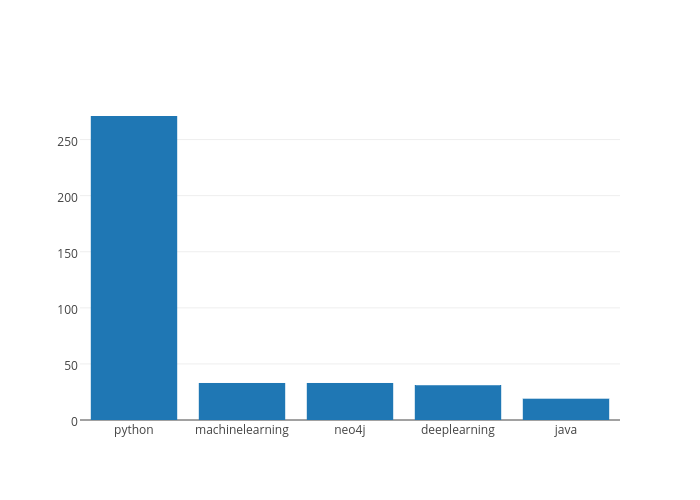

In [4]:
data = Data([Bar(x=df["hashtag"], y=df["tweets"])])

py.image.ishow({'data': data})

# What's the hashtag and mention count distribution?

In [5]:
result = %cypher MATCH (tweet:Tweet) \
                 OPTIONAL MATCH (hashtag:Hashtag)-[:TAGS]->(tweet) \
                 OPTIONAL MATCH (tweet)-[:MENTIONS]->(mention:User) \
                 RETURN tweet.id, COUNT(DISTINCT hashtag) AS hashtags, COUNT(DISTINCT mention) AS mentions
            
df = result.get_dataframe()
del df["tweet.id"]
df.head()

1156 rows affected.


,hashtags,mentions
0,1,5
1,0,1
2,2,1
3,0,2
4,0,0


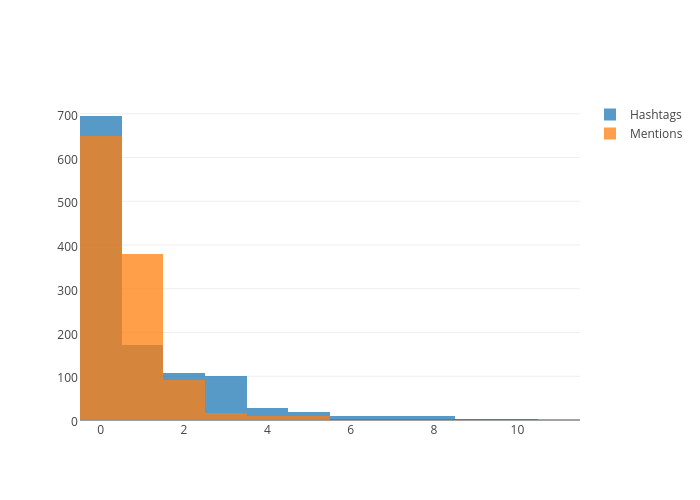

In [6]:
hashtags = Histogram(x=df["hashtags"], opacity=0.75, name="Hashtags")
mentions = Histogram(x=df["mentions"], opacity=0.75, name="Mentions")
data = Data([hashtags, mentions])
layout = Layout(barmode="overlay")
fig = Figure(data=data, layout=layout)

py.image.ishow(fig)

# Graph Algorithms

The typical workflow consists of retrieving a subgraph from Neo4j via Cypher and analyzing this graph in `igraph`.


# A subgraph of users mentioning other users

In [7]:
from igraph import Graph as IGraph

query = """
MATCH (user1:User)-[:POSTS]->(tweet:Tweet)-[:MENTIONS]->(user2:User)
RETURN user1.username, user2.username, COUNT(*) AS weight
"""

data = graph.cypher.execute(query)
data = [tuple(x) for x in data]

ig = IGraph.TupleList(data, weights=True)
ig

# Which users have the highest betweenness?

$betweenness(v) = \sum_{s, t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}}$

The betweenness centrality of a node $v$ is the number of shortest paths that pass through $v$, $\sigma_{st}(v)$,  divided by the total number of shortest paths, $\sigma_{st}$.

In [8]:
data = [(node["name"], node.betweenness()) for node in ig.vs]
top = sorted(data, key=lambda x: x[1], reverse=True)
top[:5]

[(u'neo4j', 3431.4333333333343),
 (u'sagarawasthi', 1486.0),
 (u'Dev_Topics', 1382.0),
 (u'OReillyMedia', 905.0),
 (u'rasbt', 716.0)]

# A subgraph of hashtags mutually tagging tweets

In [9]:
query = """
MATCH (h1:Hashtag)-[:TAGS]->(tweet:Tweet)<-[:TAGS]-(h2:Hashtag)
WHERE NOT (tweet)-[:RETWEETS|REPLY_TO]->() AND h1.name < h2.name AND
      NOT 'python' in [h1.name, h2.name]
RETURN h1.name, h2.name, COUNT(*) AS weight
"""

data = graph.cypher.execute(query)
tup = [tuple(x) for x in data]

ig = IGraph.TupleList(tup, weights=True)
ig

# Community detection

In [10]:
clusters = IGraph.community_walktrap(ig, weights="weight")
clusters = clusters.as_clustering()
len(clusters)

36

In [11]:
nodes = list(set([x[0] for x in data] + [x[1] for x in data]))
nodes = [{"id": x, "label": x} for x in nodes]
nodes[:5]

[{'id': u'code', 'label': u'code'},
 {'id': u'shoes', 'label': u'shoes'},
 {'id': u'nosql', 'label': u'nosql'},
 {'id': u'rest', 'label': u'rest'},
 {'id': u'pythonrulez', 'label': u'pythonrulez'}]

In [12]:
for node in nodes:
    idx = ig.vs.find(name=node["id"]).index
    node["group"] = clusters.membership[idx]
    
nodes[:5]

[{'group': 7, 'id': u'code', 'label': u'code'},
 {'group': 15, 'id': u'shoes', 'label': u'shoes'},
 {'group': 4, 'id': u'nosql', 'label': u'nosql'},
 {'group': 17, 'id': u'rest', 'label': u'rest'},
 {'group': 8, 'id': u'pythonrulez', 'label': u'pythonrulez'}]

In [13]:
edges = [{"from": x[0], "to": x[1]} for x in data]
edges[:5]

[{'from': u'aws', 'to': u'az'},
 {'from': u'job', 'to': u'kellyjobs'},
 {'from': u'addins', 'to': u'geodev'},
 {'from': u'it', 'to': u'rhtechjobs'},
 {'from': u'django', 'to': u'jobs'}]

In [14]:
from scripts.vis import vis_network
vis_network(nodes, edges, physics=True)

<blockquote class="twitter-tweet" data-partner="tweetdeck"><p lang="en" dir="ltr">Learning <a href="https://twitter.com/neo4j">@neo4j</a> &#39;s <a href="https://twitter.com/hashtag/Cypher?src=hash">#Cypher</a>. Yes Yet Another Query language but damn it&#39;s fast and pretty! <a href="https://twitter.com/hashtag/Win?src=hash">#Win</a></p>&mdash; Gregory Vangilbergen (@GregVang) <a href="https://twitter.com/GregVang/status/646288351969021952">September 22, 2015</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>